##Importing data from Github

In [1]:
import pandas as pd

# reporting date 2024/12/31 13F-HR
url = "https://raw.githubusercontent.com/Kei-Sanada/Holdings-of-Numerai-GP-LLC/main/History_Numerai_13F-HR.xlsx"

# Import Excel file and store sheet "ALL" in DataFrame
numerai_13f_history = pd.read_excel(url, sheet_name='ALL')

# Convert NaN value to 0
numerai_13f_history.fillna(0, inplace=True)

In [2]:
# Display DataFrame numerai_13f_history in tabular format
from IPython.display import display
display(numerai_13f_history.style.hide(axis="index"))

nameOfIssuer,cusip,2022-12-31 00:00:00,2023-03-31 00:00:00,2023-06-30 00:00:00,2023-09-30 00:00:00,2023-12-31 00:00:00,2024-03-31 00:00:00,2024-06-30 00:00:00,2024-09-30 00:00:00,2024-12-31 00:00:00
ABM INDS INC,000957100,0.000000,0.000000,0.000000,0.000000,0.000000,1882473.000000,0.000000,0.000000,0.000000
AGCO CORP,001084102,0.000000,0.000000,0.000000,0.000000,0.000000,1764107.000000,0.000000,0.000000,0.000000
ABERCROMBIE & FITCH CO,002896207,0.000000,0.000000,0.000000,956599.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ADVANCED MICRO DEVICES INC,007903107,0.000000,0.000000,0.000000,508342.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AIRBNB INC,009066101,0.000000,0.000000,0.000000,317916.000000,0.000000,0.000000,0.000000,2865018.000000,964287.000000
AIR PRODS & CHEMS INC,009158106,0.000000,0.000000,0.000000,0.000000,0.000000,446261.000000,0.000000,0.000000,0.000000
ALAMO GROUP INC,011311107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1756123.000000,2659619.000000,1013210.000000
ALARM COM HLDGS INC,011642105,0.000000,539504.000000,1586059.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ALBANY INTL CORP,012348108,0.000000,0.000000,0.000000,531657.000000,398871.000000,246773.000000,0.000000,0.000000,0.000000
ALCOA CORP,013872106,0.000000,0.000000,9118416.000000,2337267.000000,278290.000000,0.000000,1540441.000000,1608323.000000,0.000000


# Analysis

##AUM

In [4]:
import matplotlib.pyplot as plt

In [5]:
numerai_13f_history_aum = numerai_13f_history.copy()
numerai_13f_history_aum = numerai_13f_history_aum.drop(columns=['nameOfIssuer', 'cusip']).sum().reset_index()
numerai_13f_history_aum.columns = ['Date', 'AUM']

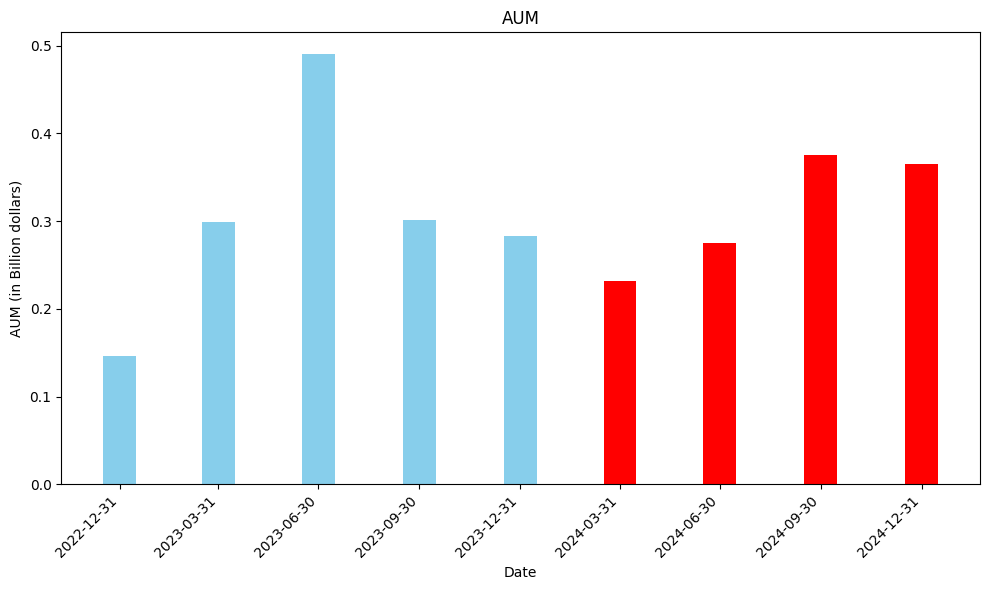

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Convert 'Date' column to datetime if it's not already
numerai_13f_history_aum['Date'] = pd.to_datetime(numerai_13f_history_aum['Date'])

# Convert AUM to billions
numerai_13f_history_aum['AUM'] = numerai_13f_history_aum['AUM'] / 1e9

# Create color array based on date condition
colors = ['red' if date >= pd.Timestamp('2024-03-31') else 'skyblue'
          for date in numerai_13f_history_aum['Date']]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(numerai_13f_history_aum['Date'], numerai_13f_history_aum['AUM'],
        color=colors, width=30.0, align='center')

plt.title('AUM')
plt.xlabel('Date')
plt.ylabel('AUM (in Billion dollars)')

# Format the x-axis to show the dates as 'YYYY-MM-DD'
plt.xticks(numerai_13f_history_aum['Date'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [7]:
# Display numbers as dollar amounts
numerai_13f_history_aum['AUM'] = numerai_13f_history_aum['AUM'].apply(lambda x: f"${x:,.2f}")

print(numerai_13f_history_aum.to_string(index=False))

      Date   AUM
2022-12-31 $0.15
2023-03-31 $0.30
2023-06-30 $0.49
2023-09-30 $0.30
2023-12-31 $0.28
2024-03-31 $0.23
2024-06-30 $0.28
2024-09-30 $0.38
2024-12-31 $0.37


##AUM Box Plot

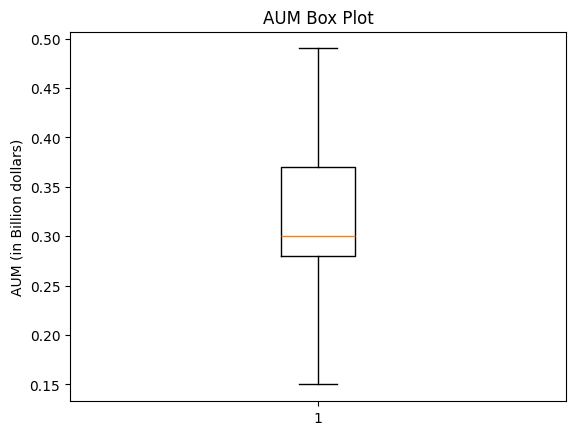

In [8]:
# Remove dollar signs and commas, then convert to float
numerai_13f_history_aum['AUM'] = numerai_13f_history_aum['AUM'].replace({'\$': '', ',': ''}, regex=True).astype(float)

plt.boxplot(numerai_13f_history_aum['AUM'])
plt.ylabel('AUM (in Billion dollars)')
plt.title('AUM Box Plot')
plt.show()

##HOLDINGS

In [9]:
numerai_13f_history_holdings = numerai_13f_history.copy()
numerai_13f_history_holdings = numerai_13f_history_holdings.drop(columns=['nameOfIssuer', 'cusip'])
non_zero_counts = (numerai_13f_history_holdings.iloc[:, 0:] != 0).sum()
numerai_13f_history_holdings = pd.DataFrame(non_zero_counts).reset_index()
numerai_13f_history_holdings.columns = ['Date', 'HOLDINGS']
numerai_13f_history_holdings['Date'] = numerai_13f_history_holdings['Date'].astype(str).str[:7]

In [10]:
numerai_13f_history_holdings

,Date,HOLDINGS
0,2022-12,111
1,2023-03,156
2,2023-06,159
3,2023-09,219
4,2023-12,232
5,2024-03,250
6,2024-06,311
7,2024-09,345
8,2024-12,389


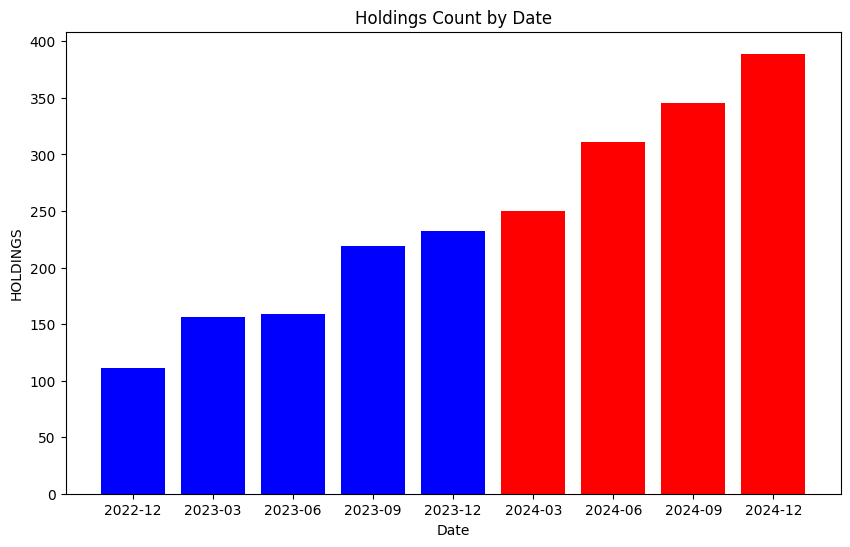

In [11]:
plt.figure(figsize=(10, 6))

# Convert 'Date' column to Timestamp objects for comparison
numerai_13f_history_holdings['Date'] = pd.to_datetime(numerai_13f_history_holdings['Date'])

# Create color array based on date condition
colors = ['red' if date >= pd.Timestamp('2024-03') else 'blue'
          for date in numerai_13f_history_holdings['Date']]

# Convert 'Date' column back to strings for plotting if necessary
numerai_13f_history_holdings['Date'] = numerai_13f_history_holdings['Date'].dt.strftime('%Y-%m')

plt.bar(numerai_13f_history_holdings['Date'],
        numerai_13f_history_holdings['HOLDINGS'],
        color=colors)

plt.title('Holdings Count by Date')
plt.xlabel('Date')
plt.ylabel('HOLDINGS')

plt.show()

##Position Size

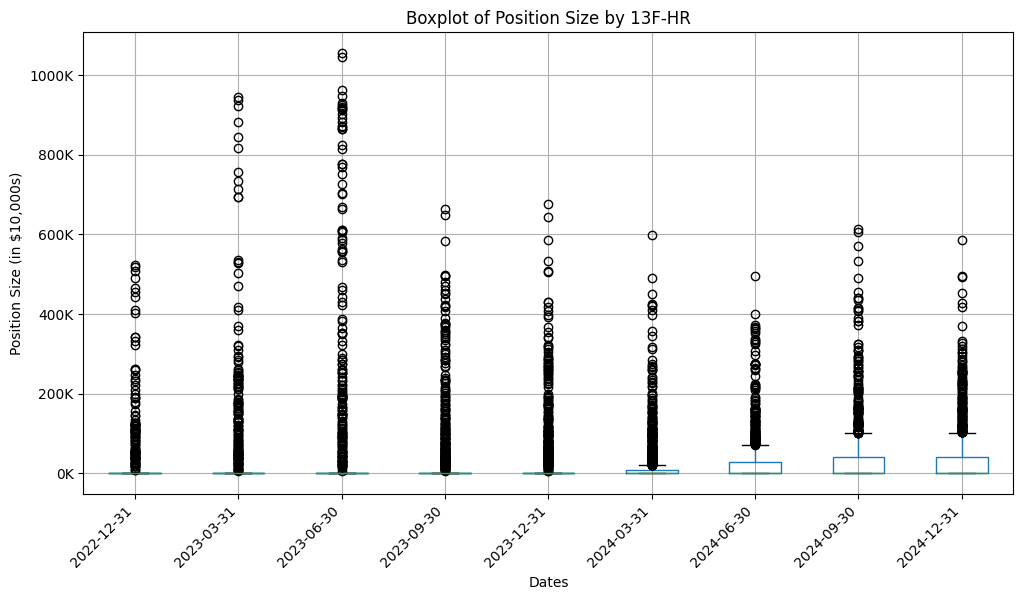

In [12]:
from matplotlib.ticker import FuncFormatter

# Select numeric columns (Exclude non-numeric columns like names or identifiers)
numerical_columns = numerai_13f_history.select_dtypes(include=['number'])

# Attempt to convert column names to datetime if they represent dates
try:
    numerical_columns.columns = pd.to_datetime(numerical_columns.columns, errors='coerce')
    numerical_columns.columns = numerical_columns.columns.strftime('%Y-%m-%d')
except:
    pass  # If conversion fails, keep the original columns

# Function to format Y-axis in $10,000 units
def format_thousands(x, pos):
    return f'{int(x / 10000)}K'  # Divide by 10,000 and append "K"

# Draw a boxplot
plt.figure(figsize=(12, 6))
numerical_columns.boxplot()
plt.xticks(rotation=45, ha='right')  # Rotate X-axis labels for better visibility
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))  # Apply Y-axis formatter
plt.title('Boxplot of Position Size by 13F-HR')
plt.ylabel('Position Size (in $10,000s)')
plt.xlabel('Dates')
plt.show()

##Histogram

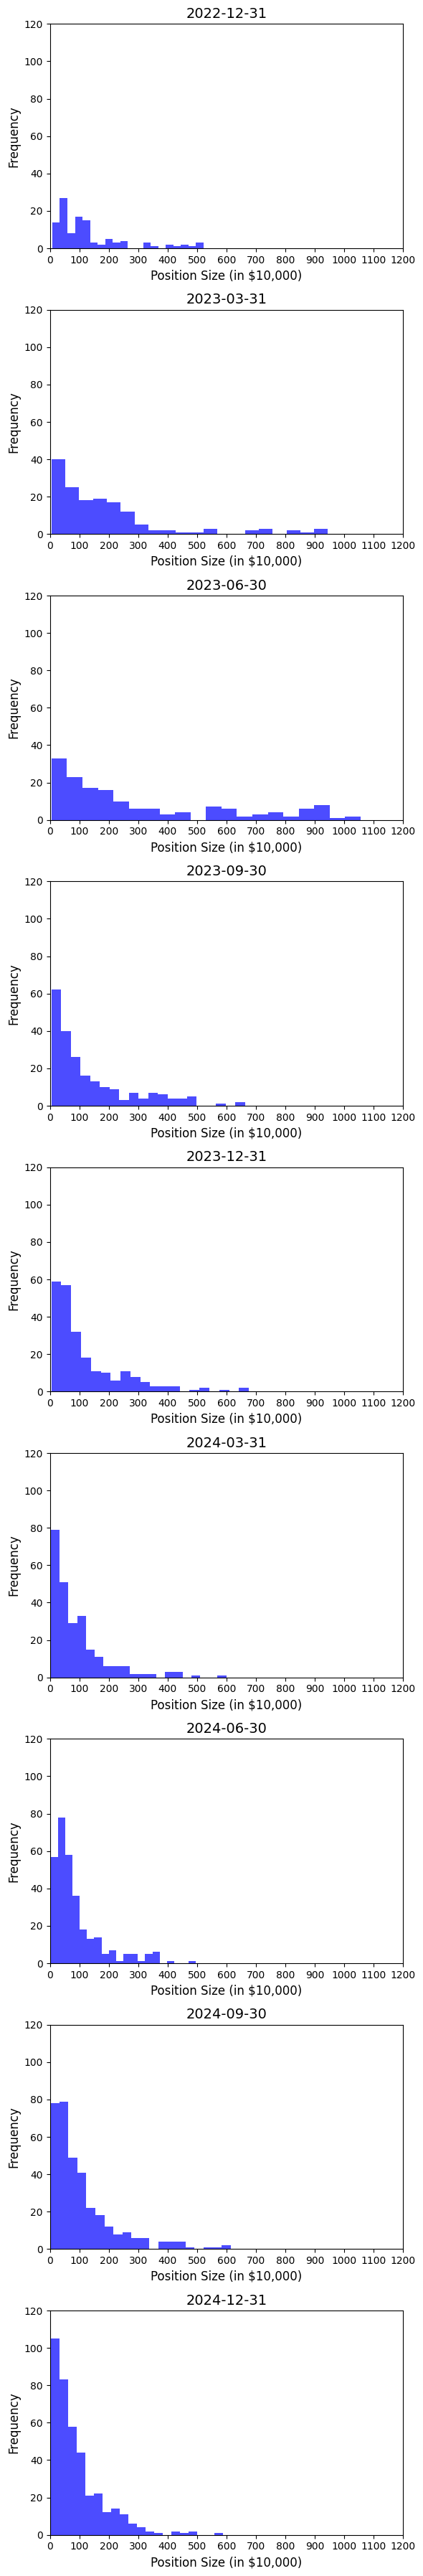

In [13]:
import matplotlib.ticker as ticker

# Automatically detect numerical columns
numerical_columns = numerai_13f_history.select_dtypes(include=['float', 'int']).columns

# Set figure size dynamically based on the number of columns
num_columns = len(numerical_columns)
fig, axes = plt.subplots(num_columns, 1, figsize=(6, 4 * num_columns))

# Iterate over each numerical column and create histograms
for i, column in enumerate(numerical_columns):
    ax = axes[i] if num_columns > 1 else axes
    # Filter out blank values (0 and NaN)
    filtered_data = numerai_13f_history[column][numerai_13f_history[column] != 0].dropna()
    if not filtered_data.empty:  # Only plot if there is data
        # Convert data to $10,000 units
        filtered_data = filtered_data / 10_000
        # Plot histogram
        ax.hist(filtered_data, bins=20, color='blue', alpha=0.7)
        # Set the graph title to match the "YYYY-MM-DD" format
        # Convert column to string before splitting
        ax.set_title(str(column).split()[0], fontsize=14)  # Extract "YYYY-MM-DD" from the column name
        # Set X-axis label
        ax.set_xlabel('Position Size (in $10,000)', fontsize=12)
        # Set Y-axis label
        ax.set_ylabel('Frequency', fontsize=12)
        # Set Y-axis maximum value to 120
        ax.set_ylim(0, 120)
        # Set X-axis maximum value to 1200 and use 100 increments
        ax.set_xlim(0, 1200)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(100))  # X-axis ticks every 100
    else:
        # Hide the plot if there is no valid data
        ax.set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

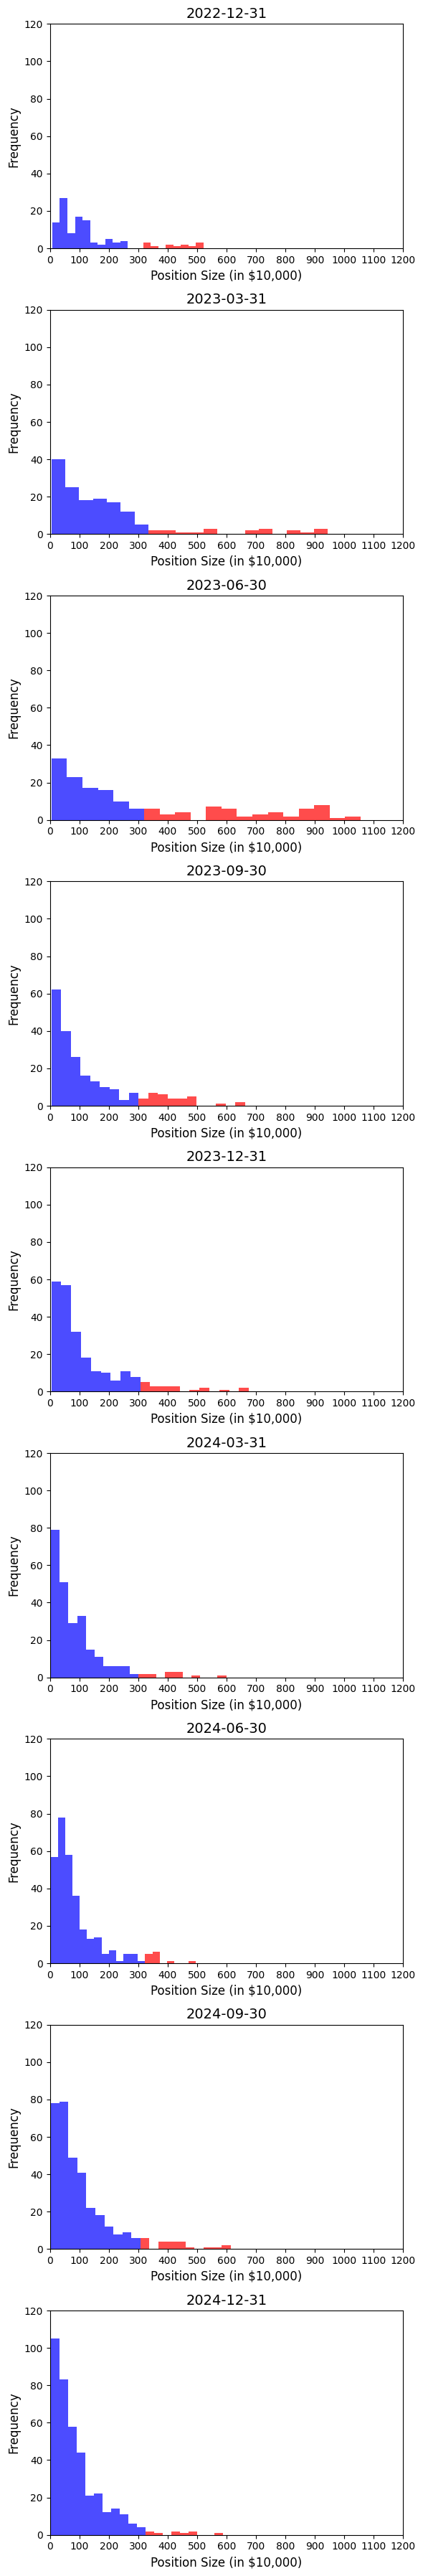

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Automatically detect numerical columns
numerical_columns = numerai_13f_history.select_dtypes(include=['float', 'int']).columns

# Set figure size dynamically based on the number of columns
num_columns = len(numerical_columns)
fig, axes = plt.subplots(num_columns, 1, figsize=(6, 4 * num_columns))

# Iterate over each numerical column and create histograms
for i, column in enumerate(numerical_columns):
    ax = axes[i] if num_columns > 1 else axes
    # Filter out blank values (0 and NaN)
    filtered_data = numerai_13f_history[column][numerai_13f_history[column] != 0].dropna()
    if not filtered_data.empty:  # Only plot if there is data
        # Convert data to $10,000 units
        filtered_data = filtered_data / 10_000
        # Plot histogram and store patches
        n, bins, patches = ax.hist(filtered_data, bins=20, color='blue', alpha=0.7)

        # Change the color of bars where X-axis value is 300 or more
        for patch, left_edge in zip(patches, bins[:-1]):  # Loop through bars and bin edges
            if left_edge >= 300:  # If the bar's X value is 300 or more
                patch.set_facecolor('red')

        # Set the graph title to match the "YYYY-MM-DD" format
        ax.set_title(str(column).split()[0], fontsize=14)  # Extract "YYYY-MM-DD" from the column name
        # Set X-axis label
        ax.set_xlabel('Position Size (in $10,000)', fontsize=12)
        # Set Y-axis label
        ax.set_ylabel('Frequency', fontsize=12)
        # Set Y-axis maximum value to 120
        ax.set_ylim(0, 120)
        # Set X-axis maximum value to 1200 and use 100 increments
        ax.set_xlim(0, 1200)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(100))  # X-axis ticks every 100
    else:
        # Hide the plot if there is no valid data
        ax.set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

##Turnover rate

###Quarterly Portfolio Turnover Rate

This calculates and visualizes the "Quarterly Portfolio Turnover Rate" using historical portfolio data from the file History_Numerai_13F-HR.xlsx. The turnover rate measures the degree of change in portfolio composition between consecutive quarters using the formula:

$$
\text{Turnover Rate} = \frac{\text{Number of Removed Holdings (from Previous Quarter)} + \text{Number of Added Holdings (in Current Quarter)}}{\text{Total Holdings in the Current Quarter}}
$$

Overview of the Calculation:  
Replace missing values (NaN) in the dataset with 0 for consistent processing.
Extract columns representing quarters (assumed to start from the 3rd column onward).
Loop through consecutive quarters to analyze portfolio changes.
Identify holdings for the previous and current quarters by filtering non-zero values.
Calculate the number of holdings removed from the previous quarter and added in the current quarter using set operations.
Compute the turnover rate for each quarter as described in the formula above.
Store the calculated turnover rates and corresponding quarters in a DataFrame.
Format the quarter data into a standard YYYY-MM-DD format for clarity.
Plot the turnover rates as a bar chart titled "Quarterly Portfolio Turnover Rate."
This program visualizes how frequently portfolio holdings are adjusted over time, providing insights into the dynamics of investment strategies. The visualization highlights the magnitude of changes in holdings, helping to identify trends and patterns in portfolio management.

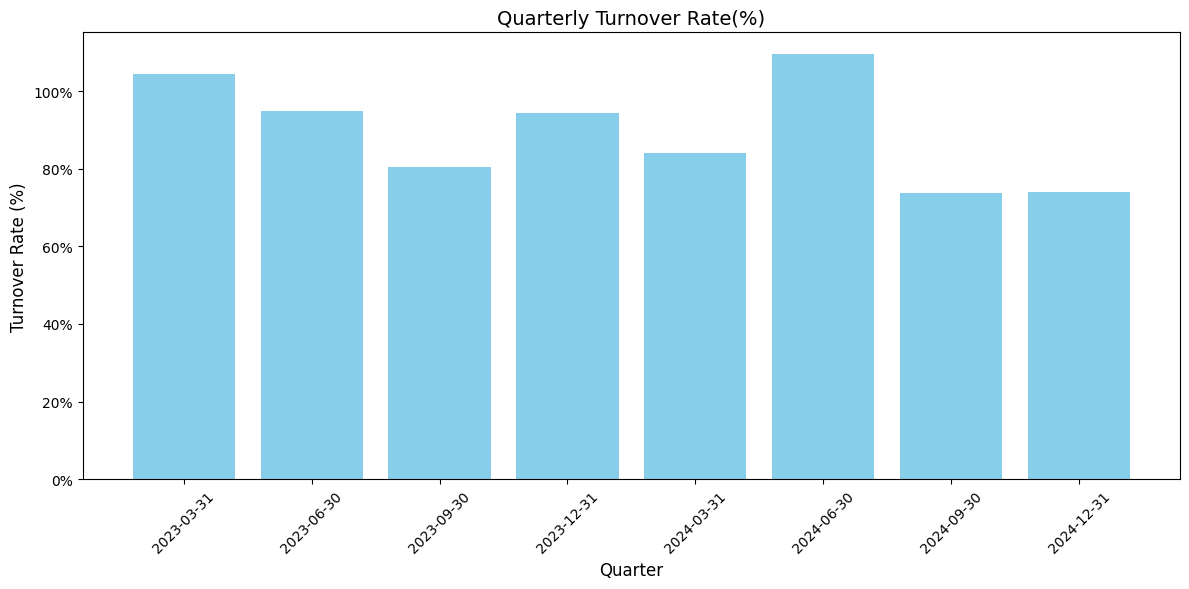

In [17]:
# Extract quarters (columns from the 3rd onward are assumed to be quarters)
quarters = numerai_13f_history.columns[2:]

# Initialize a list to store the results
quarterly_changes = []

# Iterate over consecutive quarters to calculate the required metrics
for i in range(len(quarters) - 1):
    current_quarter = quarters[i]
    next_quarter = quarters[i + 1]

    # Get holdings for the current and next quarters
    # current_holdings = set(numerai_13f_history[numerai_13f_history[current_quarter] != 0]['nameOfIssuer'])
    # next_holdings = set(numerai_13f_history[numerai_13f_history[next_quarter] != 0]['nameOfIssuer'])

    current_holdings = set(numerai_13f_history[numerai_13f_history[current_quarter] != 0]['cusip'])
    next_holdings = set(numerai_13f_history[numerai_13f_history[next_quarter] != 0]['cusip'])

    # Calculate the number of removed and added holdings
    removed_holdings = current_holdings - next_holdings
    added_holdings = next_holdings - current_holdings

    # Calculate the turnover rate
    total_holdings_next_quarter = len(next_holdings)
    turnover_rate = (len(removed_holdings) + len(added_holdings)) / total_holdings_next_quarter * 100 if total_holdings_next_quarter > 0 else 0

    # Append the results
    quarterly_changes.append({
        'Quarter': next_quarter,
        'Number of Removed Holdings (from Previous Quarter)': len(removed_holdings),
        'Number of Added Holdings (in Current Quarter)': len(added_holdings),
        'Total Holdings in the Current Quarter': total_holdings_next_quarter,
        'Turnover Rate (%)': turnover_rate
    })

# Create a DataFrame for the results
quarterly_changes_df = pd.DataFrame(quarterly_changes)

# Convert Quarter to "YYYY-MM-DD" format
quarterly_changes_df['Quarter'] = pd.to_datetime(quarterly_changes_df['Quarter']).dt.strftime('%Y-%m-%d')

# Plot the turnover rates
plt.figure(figsize=(12, 6))
plt.bar(quarterly_changes_df['Quarter'], quarterly_changes_df['Turnover Rate (%)'], color='skyblue', width=0.8)
plt.title('Quarterly Turnover Rate(%)', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Turnover Rate (%)', fontsize=12)
plt.xticks(rotation=45)

# Format Y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.tight_layout()
plt.show()

In [ ]:
quarterly_changes_df

,Quarter,Number of Removed Holdings (from Previous Quarter),Number of Added Holdings (in Current Quarter),Total Holdings in the Current Quarter,Turnover Rate (%)
0,2023-03-31,59,104,156,104.487179
1,2023-06-30,74,77,159,94.968553
2,2023-09-30,58,118,219,80.365297
3,2023-12-31,103,116,232,94.396552
4,2024-03-31,96,114,250,84.000000
5,2024-06-30,140,201,311,109.646302
6,2024-09-30,110,144,345,73.623188
7,2024-12-31,122,166,389,74.035990


In [ ]:
# Save the results to a CSV file
quarterly_changes_df.to_csv("turnover_rate.csv", index=False)

print("The CSV file 'turnover_rate.csv' has been successfully saved.")

The CSV file 'turnover_rate.csv' has been successfully saved.


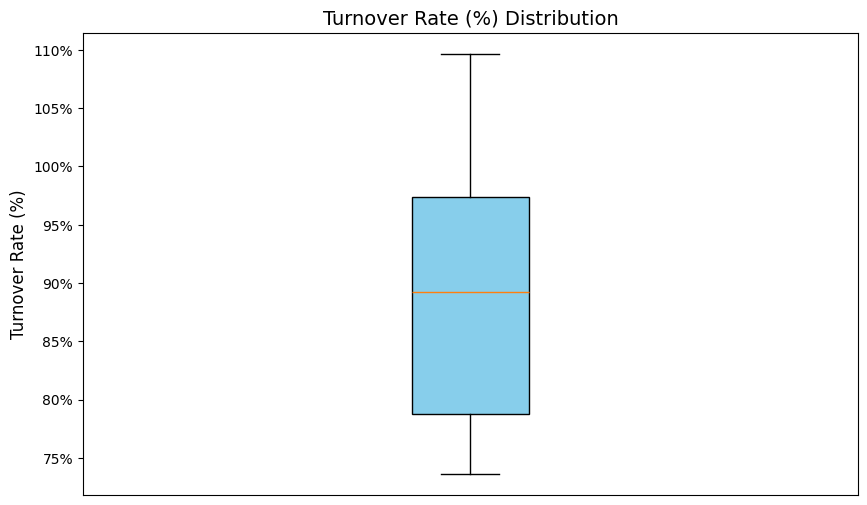

In [ ]:
# Extract quarters (columns from the 3rd onward are assumed to be quarters)
quarters = numerai_13f_history.columns[2:]

# Initialize a list to store the results
quarterly_changes = []

# Iterate over consecutive quarters to calculate the required metrics
for i in range(len(quarters) - 1):
    current_quarter = quarters[i]
    next_quarter = quarters[i + 1]

    # Get holdings for the current and next quarters
    current_holdings = set(numerai_13f_history[numerai_13f_history[current_quarter] != 0]['cusip'])
    next_holdings = set(numerai_13f_history[numerai_13f_history[next_quarter] != 0]['cusip'])

    # Calculate the number of removed and added holdings
    removed_holdings = current_holdings - next_holdings
    added_holdings = next_holdings - current_holdings

    # Calculate the turnover rate
    total_holdings_next_quarter = len(next_holdings)
    turnover_rate = (len(removed_holdings) + len(added_holdings)) / total_holdings_next_quarter * 100 if total_holdings_next_quarter > 0 else 0

    # Append the results
    quarterly_changes.append({
        'Quarter': next_quarter,
        'Turnover Rate (%)': turnover_rate
    })

# Create a DataFrame for the results
quarterly_changes_df = pd.DataFrame(quarterly_changes)

# Convert Quarter to "YYYY-MM-DD" format
quarterly_changes_df['Quarter'] = pd.to_datetime(quarterly_changes_df['Quarter']).dt.strftime('%Y-%m-%d')

# Create a box plot for Turnover Rate (%)
plt.figure(figsize=(10, 6))
plt.boxplot(quarterly_changes_df['Turnover Rate (%)'], vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.title('Turnover Rate (%) Distribution', fontsize=14)
plt.ylabel('Turnover Rate (%)', fontsize=12)

# Hide X-axis label
plt.gca().get_xaxis().set_visible(False)

# Customize the Y-axis labels to show percentage format
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Display the plot
plt.show()

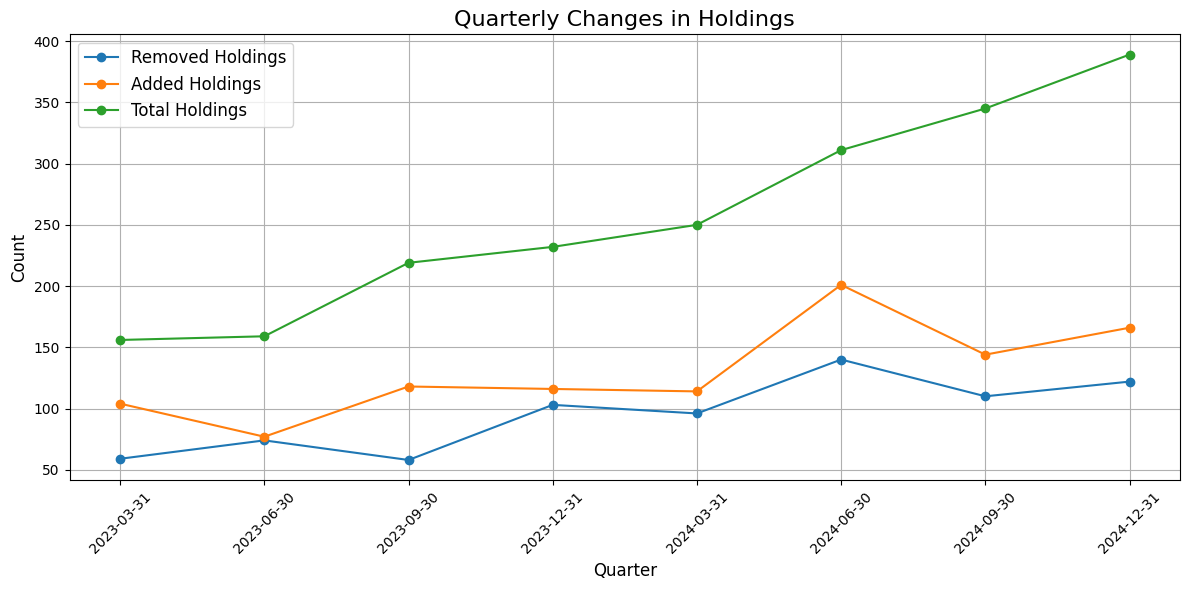

In [ ]:
# Extract quarters (columns from the 3rd onward are assumed to be quarters)
quarters = numerai_13f_history.columns[2:]

# Initialize a list to store the results
quarterly_changes = []

# Iterate over consecutive quarters to calculate the required metrics
for i in range(len(quarters) - 1):
    current_quarter = quarters[i]
    next_quarter = quarters[i + 1]

    # Get holdings for the current and next quarters
    current_holdings = set(numerai_13f_history[numerai_13f_history[current_quarter] != 0]['cusip'])
    next_holdings = set(numerai_13f_history[numerai_13f_history[next_quarter] != 0]['cusip'])

    # Calculate the number of removed and added holdings
    removed_holdings = current_holdings - next_holdings
    added_holdings = next_holdings - current_holdings

    # Calculate the total holdings in the current quarter
    total_holdings_next_quarter = len(next_holdings)

    # Append the results
    quarterly_changes.append({
        'Quarter': next_quarter,
        'Number of Removed Holdings (from Previous Quarter)': len(removed_holdings),
        'Number of Added Holdings (in Current Quarter)': len(added_holdings),
        'Total Holdings in the Current Quarter': total_holdings_next_quarter,
    })

# Create a DataFrame for the results
quarterly_changes_df = pd.DataFrame(quarterly_changes)

# Convert Quarter to "YYYY-MM-DD" format
quarterly_changes_df['Quarter'] = pd.to_datetime(quarterly_changes_df['Quarter']).dt.strftime('%Y-%m-%d')

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(quarterly_changes_df['Quarter'], quarterly_changes_df['Number of Removed Holdings (from Previous Quarter)'], label='Removed Holdings', marker='o')
plt.plot(quarterly_changes_df['Quarter'], quarterly_changes_df['Number of Added Holdings (in Current Quarter)'], label='Added Holdings', marker='o')
plt.plot(quarterly_changes_df['Quarter'], quarterly_changes_df['Total Holdings in the Current Quarter'], label='Total Holdings', marker='o')

# Add labels, title, and legend
plt.title('Quarterly Changes in Holdings', fontsize=16)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Assuming 'quarterly_changes_df' is already available
# Example structure of 'quarterly_changes_df'
# quarterly_changes_df = pd.DataFrame({
#     'Quarter': ['2022-01-01', '2022-04-01', '2022-07-01'],
#     'Number of Removed Holdings (from Previous Quarter)': [5, 10, 8],
#     'Number of Added Holdings (in Current Quarter)': [7, 9, 6],
#     'Total Holdings in the Current Quarter': [50, 55, 53]
# })

# Select relevant columns for correlation calculation
relevant_columns = [
    'Number of Removed Holdings (from Previous Quarter)',
    'Number of Added Holdings (in Current Quarter)',
    'Total Holdings in the Current Quarter'
]

# Calculate the correlation matrix
correlation_matrix = quarterly_changes_df[relevant_columns].corr()



In [ ]:
# Output the correlation matrix
correlation_matrix

,Number of Removed Holdings (from Previous Quarter),Number of Added Holdings (in Current Quarter),Total Holdings in the Current Quarter
Number of Removed Holdings (from Previous Quarter),1.000000,0.834506,0.810107
Number of Added Holdings (in Current Quarter),0.834506,1.000000,0.805458
Total Holdings in the Current Quarter,0.810107,0.805458,1.000000


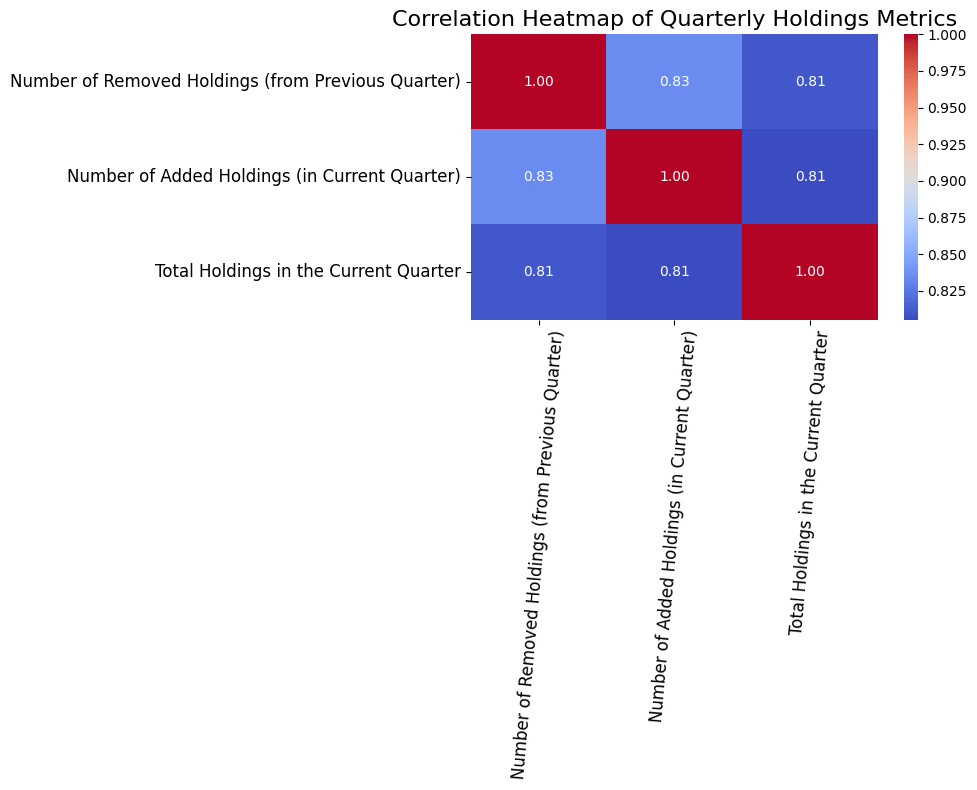

In [ ]:
import seaborn as sns

# Assuming 'quarterly_changes_df' is already available
# Example structure of 'quarterly_changes_df'
# quarterly_changes_df = pd.DataFrame({
#     'Quarter': ['2022-01-01', '2022-04-01', '2022-07-01'],
#     'Number of Removed Holdings (from Previous Quarter)': [5, 10, 8],
#     'Number of Added Holdings (in Current Quarter)': [7, 9, 6],
#     'Total Holdings in the Current Quarter': [50, 55, 53]
# })

# Select relevant columns for correlation calculation
relevant_columns = [
    'Number of Removed Holdings (from Previous Quarter)',
    'Number of Added Holdings (in Current Quarter)',
    'Total Holdings in the Current Quarter'
]

# Calculate the correlation matrix
correlation_matrix = quarterly_changes_df[relevant_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add title and labels
plt.title('Correlation Heatmap of Quarterly Holdings Metrics', fontsize=16)
plt.xticks(fontsize=12, rotation=85)
plt.yticks(fontsize=12, rotation=0)

# Display the heatmap
plt.tight_layout()
plt.show()

The program visualizes the quarterly portfolio turnover rate by calculating the change in holdings between consecutive financial quarters. It uses a dataset named `numerai_13f_history` to process and calculate the turnover rate and then plots these rates as a bar chart for easy interpretation.

The formula used to calculate the turnover rate is as follows:

$$
\text{Turnover Rate (%)} = \frac{\text{Number of Changed Holdings (Symmetric Difference)}}{\text{Total Holdings in the Next Quarter}} \times 100
$$

Here, "Number of Changed Holdings" is determined by the symmetric difference between the sets of holdings in the current quarter and the next quarter. The symmetric difference includes all holdings that are either added or removed between these two quarters.

Overview of the Calculation:  
The program starts by extracting the column names representing quarters from the dataset. For each pair of consecutive quarters, it identifies the holdings for each quarter, calculates the symmetric difference (changes), and computes the turnover rate as a percentage. These results are stored in a DataFrame for further analysis.

Finally, the program generates a bar chart to visualize the turnover rates over time, enhancing interpretation. The X-axis represents the quarters in chronological order, while the Y-axis shows the turnover rate as a percentage, formatted for readability. The visualization helps in identifying trends or patterns in portfolio turnover across quarters.

###Portfolio Turnover Rate

      Quarter  Turnover Rate (%)
0  2023-03-31          68.392036
1  2023-06-30          48.538903
2  2023-09-30          47.932516
3  2023-12-31           6.301066
4  2024-03-31          19.807002
5  2024-06-30          17.166533
6  2024-09-30          30.769235
7  2024-12-31           2.709791


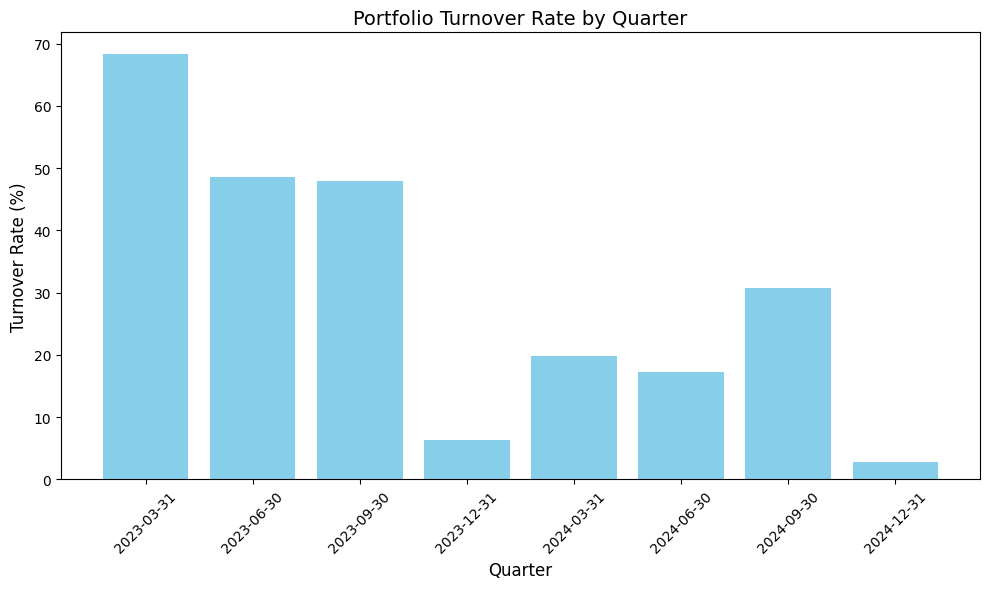

In [ ]:
# Calculate the total assets for each quarter
quarterly_totals = numerai_13f_history.iloc[:, 2:].sum()

# Calculate the turnover values (absolute difference of consecutive totals)
turnover_values = quarterly_totals.diff().abs()

# Calculate the average balance
average_balance = (quarterly_totals + quarterly_totals.shift(1)) / 2

# Calculate the turnover rate and convert to percentage
turnover_rate = (turnover_values / average_balance) * 100  # Convert to percentage

# Compile the results into a DataFrame
turnover_df = pd.DataFrame({
    "Quarter": pd.to_datetime(quarterly_totals.index).strftime('%Y-%m-%d'), # Convert index to datetime
    "Turnover Rate (%)": turnover_rate  # Update column name to reflect percentage
}).dropna()

# Reset index for cleaner display
turnover_df.reset_index(drop=True, inplace=True)

# Output the formatted table
print(turnover_df)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(turnover_df["Quarter"], turnover_df["Turnover Rate (%)"], color='skyblue')
plt.title("Portfolio Turnover Rate by Quarter", fontsize=14)
plt.xlabel("Quarter", fontsize=12)
plt.ylabel("Turnover Rate (%)", fontsize=12)  # Update label to percentage
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Try adding a Ticker
I couldn't find free solution to convert cusip to Ticker.\
If you have a better way, please let me know.

The following process takes about 20 minutes.\
Also, it is not always possible to get the correct ticker.

In [ ]:
#Install yahooquery library
!pip install yahooquery

In [ ]:
from yahooquery import search

def get_ticker_symbol(company_name):
    try:
        result = search(company_name)
        if 'quotes' in result and len(result['quotes']) > 0:
            return result['quotes'][0]['symbol']
        else:
            return None  # Return None if JSONDecodeError is encountered
    except:
        return None  # Returns None in case of other errors

In [ ]:
import time

# Create a list of company names
company_names = numerai_13f_history['nameOfIssuer']

# Create an empty list to store the ticker symbols
ticker_symbols = []

# Iterate over the company names and get the ticker symbols
for company_name in company_names:
    time.sleep(0.5)  # Add a delay of 0.5 second between each request
    ticker_symbol = get_ticker_symbol(company_name)
    ticker_symbols.append(ticker_symbol)


In [ ]:
# Add ticker symbol as a new column
numerai_13f_history_ticker = numerai_13f_history.copy()
numerai_13f_history_ticker.insert(2, 'ticker', ticker_symbols)

In [ ]:
numerai_13f_history_ticker.to_excel('Numerai_13F_History_with_Ticker.xlsx', index=False)
display(numerai_13f_history_ticker.style.hide(axis="index"))